# Applying the CRISP-DM Method to a Business Problem

CRISP-DM stands for cross-industry process for data mining. It provides a structured approach to planning a data mining project. It is a robust and well-proven methodology.

This model is an idealised sequence of events. In practice many of the tasks can be performed in a different order and it will often be necessary to backtrack to previous tasks and repeat certain actions.


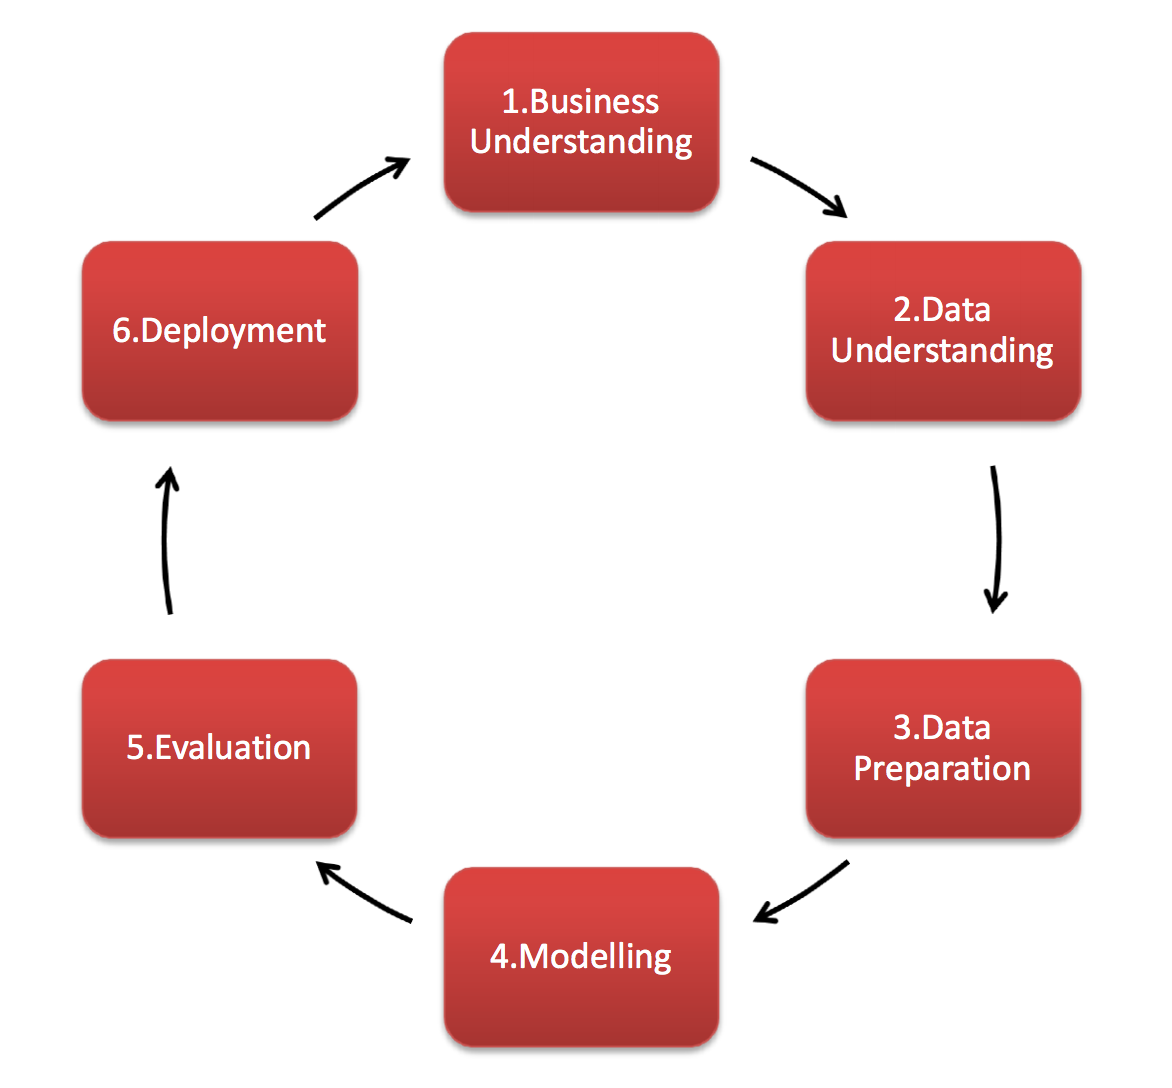

**Each phase of the process:**
2. [Data Understanding](#Dataunderstanding)
    1. [Initial Data Report](#Datareport)
    2. [Describe Data](#Describedata)
    3. [Initial Data Exploration](#Exploredata) 
    4. [Verify Data Quality](#Verifydataquality)
        1. [Missing Data](#MissingData) 
        2. [Outliers](#Outliers) 
    5. [Data Quality Report](#Dataqualityreport)
3. [Data Preparation](#Datapreparation)
    1. [Select Your Data](#Selectyourdata)
    2. [Cleanse the Data](#Cleansethedata)
        1. [Label Encoding](#labelEncoding)
        2. [Drop Unnecessary Columns](#DropCols)
        3. [Altering Datatypes](#AlteringDatatypes)
        4. [Dealing With Zeros](#DealingZeros)
    3. [Construct Required Data](#Constructrequireddata)
    4. [Integrate Data](#Integratedata)
4. [Exploratory Data Analysis](#EDA)
5. [Modelling](#Modelling)
    1. [Modelling Technique](#ModellingTechnique)
    2. [Modelling Assumptions](#ModellingAssumptions)
    3. [Build Model](#BuildModel)
    4. [Assess Model](#AssessModel)
6. [Evaluation](#Evaluation)
7. [Deployment](#Deployment)

https://www.sv-europe.com/crisp-dm-methodology/


# 5. Stage Four - Modelling <a class="anchor" id="Modelling"></a>
As the first step in modelling, you'll select the actual modelling technique that you'll be using. Although you may have already selected a tool during the business understanding phase, at this stage you'll be selecting the specific modelling technique e.g. decision-tree building with C5.0, or neural network generation with back propagation. If multiple techniques are applied, perform this task separately for each technique.



## 5.1. Modelling technique <a class="anchor" id="ModellingTechnique"></a>

Se planea utilizar dos modelos; Random Forest y red neuronal. Este notebook se centra en el Random Forest y el proximo en la red neuronal. El modelo se probará con los datos completos así como el fichero con caracteristicas reducidad. Empezaremos por crear los modelos para la predcición del sílice desfasado una hora (`final_silica_p_lag1`) correspondietne a los timestamp de los parámetros de operación (se deja la predicción con una hora de antelación, `final_silica_p_lag2`, para trabajos futuros).

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import optuna
import sklearn
import matplotlib.pyplot as plt
import pickle

### Preparación de datos

Carga de datos del fichero guardado anteriormete. Se utiizará la semana final de datos para validar los modelos. El resto para crear los modelos

In [29]:
df = pd.read_csv('data_cleaned.csv', parse_dates=True, index_col='datetime')
validation_data = df.last('1W')
model_data = df[df.index[0]:validation_data.index[0]]
print(df.shape, model_data.shape, validation_data.shape)

(184004, 23) (158085, 23) (25920, 23)


In [30]:
validation_data.info()
model_data.info()
print(validation_data.shape, model_data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25920 entries, 2017-09-03 22:00:00 to 2017-09-09 21:59:40
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   iron_p               25920 non-null  float64
 1   silica_p             25920 non-null  float64
 2   starch_f             25920 non-null  float64
 3   amina_f              25920 non-null  float64
 4   ore_f                25920 non-null  float64
 5   ore_pH               25920 non-null  float64
 6   ore_density          25920 non-null  float64
 7   c1_air_f             25920 non-null  float64
 8   c2_air_f             25920 non-null  float64
 9   c3_air_f             25920 non-null  float64
 10  c4_air_f             25920 non-null  float64
 11  c5_air_f             25920 non-null  float64
 12  c6_air_f             25920 non-null  float64
 13  c7_air_f             25920 non-null  float64
 14  c1_level             25920 non-null  float64
 15  c

Se elinminan las columnas a predecir de la lista de datos para crear los modelos.

In [31]:
columns = df.columns
features = columns[:-2]
print(features)
X = model_data[features]
y_1lag = model_data[columns[-2]]
y_2lag = model_data[columns[-1]]

Index(['iron_p', 'silica_p', 'starch_f', 'amina_f', 'ore_f', 'ore_pH',
       'ore_density', 'c1_air_f', 'c2_air_f', 'c3_air_f', 'c4_air_f',
       'c5_air_f', 'c6_air_f', 'c7_air_f', 'c1_level', 'c2_level', 'c3_level',
       'c4_level', 'c5_level', 'c6_level', 'c7_level'],
      dtype='object')


### Optmizar hyperparametros

Se utilizará la lbirería `Optuna` para optimzar el parámetro max_depth y n_estimators. En cada iteración del optimizador se guarda

In [5]:
%%time
X_model = model_data[features]
y_model = model_data['final_silica_p_lag1']
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
    n_estimators = trial.suggest_int('n_estimators', 20, 200, step=20)
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth, n_estimators=n_estimators,random_state = 42)
    score = sklearn.model_selection.cross_val_score(regressor_obj, X_model, y_model, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error')
    accuracy = score.mean()
    with open('./rf-models/rf-models-complete{}.pickle'.format(trial.number), 'wb') as fout:
        pickle.dump(regressor_obj, fout)
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2020-06-24 00:39:36,321] Finished trial#0 with value: -1.158353340887927 with parameters: {'rf_max_depth': 17.209165158179182, 'n_estimators': 100}. Best is trial#0 with value: -1.158353340887927.
[I 2020-06-24 00:40:23,193] Finished trial#1 with value: -0.8988612625757995 with parameters: {'rf_max_depth': 2.4920851540360838, 'n_estimators': 120}. Best is trial#1 with value: -0.8988612625757995.
[I 2020-06-24 00:41:10,299] Finished trial#2 with value: -0.8988612625757995 with parameters: {'rf_max_depth': 2.405216461581864, 'n_estimators': 120}. Best is trial#1 with value: -0.8988612625757995.
[I 2020-06-24 00:42:07,121] Finished trial#3 with value: -0.89114775150607 with parameters: {'rf_max_depth': 3.365051711366973, 'n_estimators': 100}. Best is trial#3 with value: -0.89114775150607.
[I 2020-06-24 00:50:05,981] Finished trial#4 with value: -1.1564407935397587 with parameters: {'rf_max_depth': 26.138009950850954, 'n_estimators': 200}. Best is trial#3 with value: -0.89114775150607.


CPU times: user 8.63 s, sys: 2.18 s, total: 10.8 s
Wall time: 2h 48min 4s


In [6]:
print(study.best_trial)

FrozenTrial(number=12, value=-0.890708288893025, datetime_start=datetime.datetime(2020, 6, 24, 1, 6, 51, 788872), datetime_complete=datetime.datetime(2020, 6, 24, 1, 8, 11, 751667), params={'rf_max_depth': 3.2834928423616754, 'n_estimators': 140}, distributions={'rf_max_depth': LogUniformDistribution(high=32, low=2), 'n_estimators': IntUniformDistribution(high=200, low=20, step=20)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=12, state=TrialState.COMPLETE)


In [7]:
best_trial_comp = study.best_trial.number
print(best_trial_comp)

12


In [33]:
# best_trial_comp = 12
model_complete = pickle.load(open('./rf-models/rf-models-complete{}.pickle'.format(best_trial_comp), 'br'))
X_val = validation_data[features]
y_val1lag = validation_data[columns[-2]]

In [34]:
%%time
model_complete.fit(X, y_1lag)

CPU times: user 1min 46s, sys: 33 ms, total: 1min 46s
Wall time: 1min 46s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [35]:
val_predictions = model_complete.predict(X_val)
print(val_predictions)

[2.72040009 2.72040009 2.72040009 ... 2.72040009 2.72040009 2.72040009]


In [36]:
error = abs(val_predictions - y_val1lag.values)
print(error.mean())

1.0415292429496394


In [37]:
mape = error/y_val1lag.values*100
print(mape.mean())

40.84656052526213


In [28]:
plt.plot(y_val1lag.values, label='real')
plt.plot(val_predictions, label='prediction')
plt.legend()
plt.title('Radnom forest validation with full features')
plt.ylabel('Sílice (%)')
plt.savefig('rf-full-validation.pdf')
plt.show()

In [27]:
print(mae.mean(), mape.mean())

1.0415292429496394 40.84656052526213


### Reduced data

In [38]:
df_red = pd.read_csv('data_reduced.csv', parse_dates=True, index_col='datetime')
reduced_validation_data = df_red.last('1W')
reduced_model_data = df_red[df_red.index[0]:reduced_validation_data.index[0]]
print(df_red.shape)

(184004, 16)


In [39]:
columns = df_red.columns
print(columns)
features = columns.drop(['final_silica_p_lag1'])
print(features)
X_reduced = reduced_model_data[features]
y_1lag_reduced = reduced_model_data['final_silica_p_lag1']
print(X_reduced.head())
y_1lag_reduced.head()

Index(['amina_f', 'c1_air_f', 'c1_level', 'c2_air_f', 'c3_air_f', 'c3_level',
       'c4_air_f', 'c4_level', 'c5_air_f', 'c5_level', 'c7_air_f', 'c7_level',
       'final_silica_p_lag1', 'ore_density', 'ore_f', 'ore_pH'],
      dtype='object')
Index(['amina_f', 'c1_air_f', 'c1_level', 'c2_air_f', 'c3_air_f', 'c3_level',
       'c4_air_f', 'c4_level', 'c5_air_f', 'c5_level', 'c7_air_f', 'c7_level',
       'ore_density', 'ore_f', 'ore_pH'],
      dtype='object')
                     amina_f  c1_air_f  c1_level  c2_air_f  c3_air_f  \
datetime                                                               
2017-07-29 07:45:20  508.545   250.664   474.470   309.242   302.387   
2017-07-29 07:45:40  507.568   251.807   488.477   302.388   300.850   
2017-07-29 07:46:00  516.113   251.499   495.083   300.103   300.762   
2017-07-29 07:46:20  512.329   252.422   514.000   300.454   300.103   
2017-07-29 07:46:40  516.235   251.279   515.710   301.289   299.927   

                     c3_level 

datetime
2017-07-29 07:45:20    2.97
2017-07-29 07:45:40    2.97
2017-07-29 07:46:00    2.97
2017-07-29 07:46:20    2.97
2017-07-29 07:46:40    2.97
Name: final_silica_p_lag1, dtype: float64

In [6]:
%%time
X_model = reduced_model_data[features]
y_model = reduced_model_data['final_silica_p_lag1']
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    n_estimators = trial.suggest_int('n_estimators', 20, 200, step=20)
    regressor_obj = sklearn.ensemble.RandomForestRegressor(max_depth=rf_max_depth, n_estimators=n_estimators,random_state = 42)
    score = sklearn.model_selection.cross_val_score(regressor_obj, X_model, y_model, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error')
    accuracy = score.mean()
    with open('./rf-models/rf-models-reduced{}.pickle'.format(trial.number), 'wb') as fout:
        pickle.dump(regressor_obj, fout)
    return accuracy

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

[I 2020-06-24 20:12:34,830] Finished trial#0 with value: -1.2030362750456969 with parameters: {'rf_max_depth': 10, 'n_estimators': 160}. Best is trial#0 with value: -1.2030362750456969.
[I 2020-06-24 20:13:09,781] Finished trial#1 with value: -1.2503017215682761 with parameters: {'rf_max_depth': 16, 'n_estimators': 20}. Best is trial#0 with value: -1.2030362750456969.
[I 2020-06-24 20:15:02,454] Finished trial#2 with value: -1.1050917218478 with parameters: {'rf_max_depth': 7, 'n_estimators': 120}. Best is trial#2 with value: -1.1050917218478.
[I 2020-06-24 20:16:51,419] Finished trial#3 with value: -1.1923380211505734 with parameters: {'rf_max_depth': 11, 'n_estimators': 80}. Best is trial#2 with value: -1.1050917218478.
[I 2020-06-24 20:23:42,907] Finished trial#4 with value: -1.2423039818881747 with parameters: {'rf_max_depth': 24, 'n_estimators': 200}. Best is trial#2 with value: -1.1050917218478.
[I 2020-06-24 20:25:43,586] Finished trial#5 with value: -1.2345651772424693 with par

CPU times: user 13.9 s, sys: 2.95 s, total: 16.9 s
Wall time: 3h 3min 7s


In [7]:
print(study.best_trial)

FrozenTrial(number=142, value=-0.8891830670328101, datetime_start=datetime.datetime(2020, 6, 24, 23, 10, 3, 341954), datetime_complete=datetime.datetime(2020, 6, 24, 23, 10, 15, 373899), params={'rf_max_depth': 2, 'n_estimators': 40}, distributions={'rf_max_depth': IntUniformDistribution(high=32, low=2, step=1), 'n_estimators': IntUniformDistribution(high=200, low=20, step=20)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=142, state=TrialState.COMPLETE)


In [8]:
best_trial = study.best_trial.number
print(best_trial)

142


In [40]:
best_trial = 142
model_reduced = pickle.load(open('./rf-models/rf-models-reduced{}.pickle'.format(best_trial), 'br'))
X_red_val = reduced_validation_data[features]
y_red_val1lag = reduced_validation_data[columns[-4]]

In [41]:
%%time
model_reduced.fit(X_red_val, y_red_val1lag)

CPU times: user 2.12 s, sys: 21 µs, total: 2.12 s
Wall time: 2.12 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [42]:
%%time 
red_val_predictions = model_reduced.predict(X_red_val)
print(red_val_predictions)

[4.01326837 4.01326837 4.01326837 ... 2.83359981 2.83359981 2.83359981]
CPU times: user 27.9 ms, sys: 42 µs, total: 27.9 ms
Wall time: 26.5 ms


In [43]:
%%time
red_error = abs(red_val_predictions - y_red_val1lag.values)
print(red_error.mean())

0.6311283264303704
CPU times: user 2.31 ms, sys: 27 µs, total: 2.34 ms
Wall time: 1.83 ms


In [44]:
red_mape = (red_error/y_red_val1lag.values).mean()
print(red_mape*100)

26.31254505809676


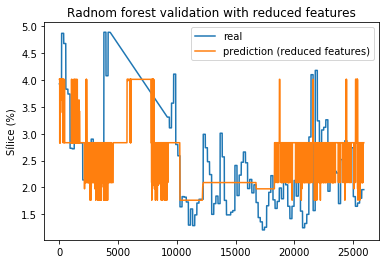

In [45]:
plt.plot(y_red_val1lag.values, label='real')
plt.plot(red_val_predictions, label='prediction (reduced features)')
plt.legend()
plt.title('Radnom forest validation with reduced features')
plt.ylabel('Sílice (%)')
plt.savefig('rf-reduced-validation.pdf')
plt.show()

In [15]:
print(red_mae.mean(), red_mape.mean())

0.6311283264303704 26.312545058096756


## 5.2. Modelling assumptions <a class="anchor" id="ModellingAssumptions"></a>
Many modelling techniques make specific assumptions about the data, for example that all attributes have uniform distributions, no missing values allowed, class attribute must be symbolic etc. Record any assumptions made.

- 
- 


## 5.3. Build Model <a class="anchor" id="BuildModel"></a>
Run the modelling tool on the prepared dataset to create one or more models.

**Parameter settings** - With any modelling tool there are often a large number of parameters that can be adjusted. List the parameters and their chosen values, along with the rationale for the choice of parameter settings.

**Models** - These are the actual models produced by the modelling tool, not a report on the models.

**Model descriptions** - Describe the resulting models, report on the interpretation of the models and document any difficulties encountered with their meanings.

## 5.4. Assess Model <a class="anchor" id="AssessModel"></a>
Interpret the models according to your domain knowledge, your data mining success criteria and your desired test design. Judge the success of the application of modelling and discovery techniques technically, then contact business analysts and domain experts later in order to discuss the data mining results in the business context. This task only considers models, whereas the evaluation phase also takes into account all other results that were produced in the course of the project.

At this stage you should rank the models and assess them according to the evaluation criteria. You should take the business objectives and business success criteria into account as far as you can here. In most data mining projects a single technique is applied more than once and data mining results are generated with several different techniques. 

**Model assessment** - Summarise the results of this task, list the qualities of your generated models (e.g.in terms of accuracy) and rank their quality in relation to each other.

**Revised parameter settings** - According to the model assessment, revise parameter settings and tune them for the next modelling run. Iterate model building and assessment until you strongly believe that you have found the best model(s). Document all such revisions and assessments.